In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import community
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Data Loading
Load cubic spline interpolated price data for all 4 metals (6 series each).

In [2]:
# Load data files
metals = {
    'Cobalt': pd.read_csv('data/ALL_cobalt_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date'),
    'Copper': pd.read_csv('data/ALL_copper_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date'),
    'Lithium': pd.read_csv('data/ALL_lithium_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date'),
    'Nickel': pd.read_csv('data/ALL_nickel_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date')
}

# Display basic info
for metal, df in metals.items():
    print(f"{metal}: {df.shape[0]} rows, {df.shape[1]} series")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")
    print(f"  Columns: {', '.join(df.columns)}")
    print()

Cobalt: 3876 rows, 6 series
  Date range: 2012-03-02 00:00:00 to 2025-11-18 00:00:00
  Columns: CODALY, COLMEX, COLMEA, COWUXI, COCOMX, COSMMS

Copper: 2342 rows, 6 series
  Date range: 2017-01-01 00:00:00 to 2025-12-31 00:00:00
  Columns: CUDALY, CUCOMX, CULMEX, CUSMMG, CUSHFE, CUETFC

Lithium: 2202 rows, 7 series
  Date range: 2017-05-10 00:00:00 to 2025-12-09 00:00:00
  Columns: LIDALY, LISAME, LICOMX, LILAMC, LIEALC, LIEABG, LILMEX

Nickel: 2857 rows, 6 series
  Date range: 2016-04-04 00:00:00 to 2025-11-18 00:00:00
  Columns: NIDALY, NILMEX, NIETFN, NISHFE, NIWUXI, NIINDA



## 2. Compute Returns

Calculate regular returns (percent change) for all price series.

In [3]:
# Convert prices to returns for all metals
metals_returns = {}

for metal, df in metals.items():
    # Calculate returns: (price_t - price_t-1) / price_t-1
    returns = df.pct_change()
    metals_returns[metal] = returns
    
    print(f"{metal} returns:")
    print(f"  Shape: {returns.shape}")
    print(f"  Mean return range: {returns.mean().min():.6f} to {returns.mean().max():.6f}")
    print(f"  Std dev range: {returns.std().min():.4f} to {returns.std().max():.4f}")
    print()

# Update the metals dictionary to use returns
metals = metals_returns

Cobalt returns:
  Shape: (3876, 6)
  Mean return range: -0.000573 to 0.001289
  Std dev range: 0.0105 to 0.0186

Copper returns:
  Shape: (2342, 6)
  Mean return range: -0.000390 to 0.001018
  Std dev range: 0.0087 to 0.0254

Lithium returns:
  Shape: (2202, 7)
  Mean return range: -0.001831 to 0.000737
  Std dev range: 0.0062 to 0.0652

Nickel returns:
  Shape: (2857, 6)
  Mean return range: -0.000330 to 0.000424
  Std dev range: 0.0155 to 0.0222



## 3. Common Timeframe Identification

Find the overlapping period where all 24 series have valid data.

In [4]:
# Combine all dataframes
all_series = pd.concat(list(metals.values()), axis=1)

# Create mapping of series to metal
series_to_metal = {}
for metal, df in metals.items():
    for col in df.columns:
        series_to_metal[col] = metal

# Exclude LISAME series
lisame_cols = [col for col in all_series.columns if 'LISAME' in col]
if lisame_cols:
    print(f"Excluding LISAME series: {lisame_cols}")
    all_series = all_series.drop(columns=lisame_cols)

print(f"\nCombined dataset: {all_series.shape}")
print(f"Date range before alignment: {all_series.index.min()} to {all_series.index.max()}")
print(f"\nMissing values per series:")
print(all_series.isnull().sum())

Excluding LISAME series: ['LISAME']

Combined dataset: (3946, 24)
Date range before alignment: 2012-03-02 00:00:00 to 2025-12-31 00:00:00

Missing values per series:
CODALY    1292
COLMEX      71
COLMEA    1293
COWUXI    1293
COCOMX    2415
COSMMS    3199
CUDALY    1606
CUCOMX    1606
CULMEX    1606
CUSMMG    1605
CUSHFE    1606
CUETFC    3472
LIDALY    1745
LICOMX    2740
LILAMC    3373
LIEALC    3264
LIEABG    3243
LILMEX    2795
NIDALY    1280
NILMEX    1090
NIETFN    3163
NISHFE    1281
NIWUXI    1281
NIINDA    1280
dtype: int64


In [5]:
# Find common timeframe with complete data
# Strategy: Find the period where all 24 series have non-null values

# Count non-null values per date across all series
complete_dates = all_series.notna().all(axis=1)
complete_data = all_series[complete_dates]

if len(complete_data) == 0:
    # Fallback: use the intersection of date ranges with most data
    print("\nNo dates with all 24 series complete. Finding best overlap...")
    
    # For each series, find first and last valid dates
    series_ranges = {}
    for col in all_series.columns:
        valid_data = all_series[col].dropna()
        if len(valid_data) > 0:
            series_ranges[col] = (valid_data.index.min(), valid_data.index.max())
    
    # Find the common period (latest start, earliest end)
    common_start = max(start for start, end in series_ranges.values())
    common_end = min(end for start, end in series_ranges.values())
    
    print(f"\nCommon period: {common_start} to {common_end}")
    
    # Extract this period
    aligned_data = all_series.loc[common_start:common_end].copy()
    
    # Check coverage
    coverage = aligned_data.notna().sum() / len(aligned_data) * 100
    print(f"\nData coverage in common period:")
    print(coverage.sort_values(ascending=False))
    
    # Use only series with >90% coverage
    good_series = coverage[coverage > 90].index.tolist()
    if len(good_series) < 24:
        print(f"\nUsing {len(good_series)} series with >90% coverage")
        aligned_data = aligned_data[good_series]
    
    # Forward fill small gaps (max 5 days)
    aligned_data = aligned_data.fillna(method='ffill', limit=5)
    
    # Drop any remaining rows with NaN
    aligned_data = aligned_data.dropna()
else:
    common_start = complete_data.index.min()
    common_end = complete_data.index.max()
    aligned_data = complete_data

# Exclude weekend days (Saturday=5, Sunday=6)
weekdays_only = aligned_data.index.dayofweek < 5
aligned_data = aligned_data[weekdays_only]

print(f"\n✓ Final aligned dataset (weekdays only):")
print(f"  Period: {aligned_data.index.min()} to {aligned_data.index.max()}")
print(f"  Duration: {(aligned_data.index.max() - aligned_data.index.min()).days} days")
print(f"  Observations: {len(aligned_data)} (weekdays only)")
print(f"  Series: {len(aligned_data.columns)}")


✓ Final aligned dataset (weekdays only):
  Period: 2024-03-07 00:00:00 to 2025-11-18 00:00:00
  Duration: 621 days
  Observations: 443 (weekdays only)
  Series: 24


## 4. Correlation Analysis

Compute pairwise correlations across all aligned return series.

In [6]:
# Compute correlation matrix
corr_matrix = aligned_data.corr()

print(f"Correlation matrix: {corr_matrix.shape}")
print(f"\nCorrelation statistics:")
print(f"  Mean: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean():.3f}")
print(f"  Median: {np.median(corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]):.3f}")
print(f"  Min: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].min():.3f}")
print(f"  Max: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max():.3f}")

Correlation matrix: (24, 24)

Correlation statistics:
  Mean: 0.089
  Median: 0.041
  Min: -0.195
  Max: 0.943


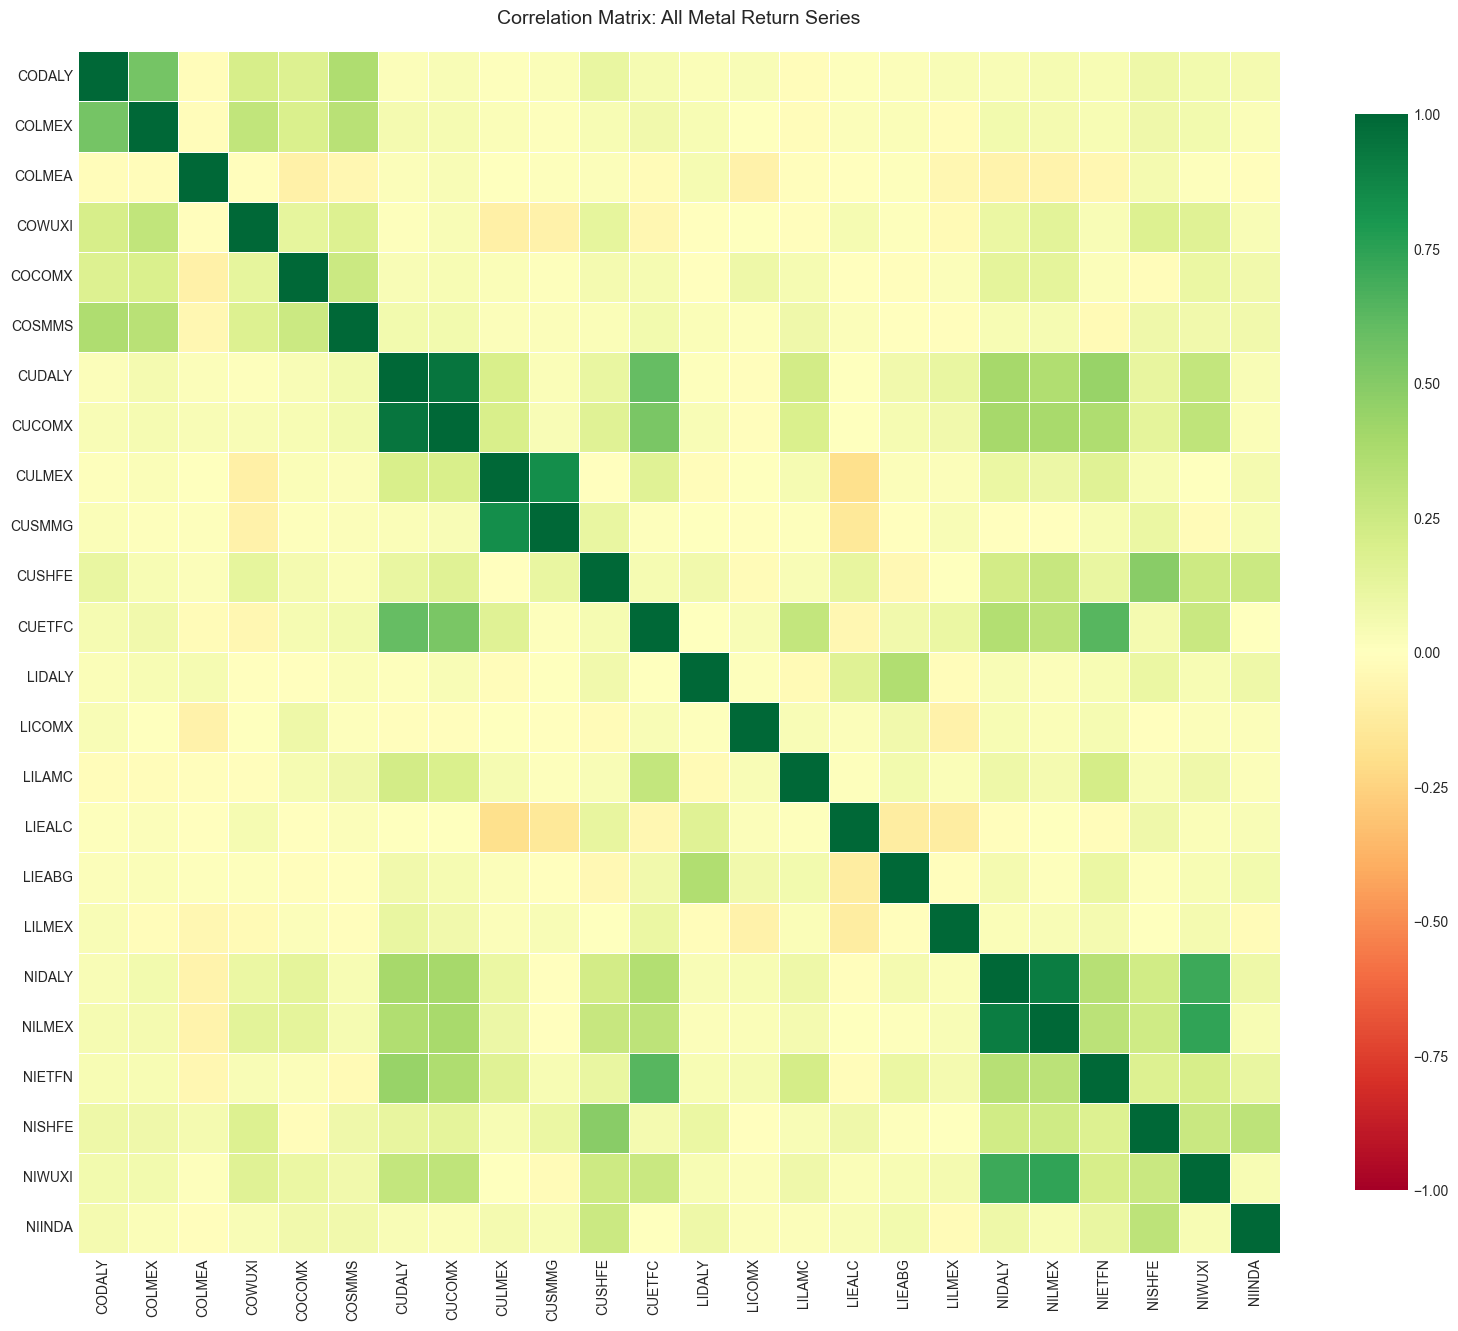

In [7]:
# Visualize full correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: All Metal Return Series', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 5. Network Visualization

Create a correlation network graph to reveal relationships between metals and series.

**Design choices:**
- **Nodes**: Each return series
- **Node colors**: Color-coded by metal (Cobalt=blue, Copper=orange, Lithium=green, Nickel=purple)
- **Edges**: Shown only for correlations > 0.3 to reduce clutter
- **Edge thickness**: Proportional to correlation strength
- **Layout**: Force-directed layout with community detection to reveal clustering patterns

In [8]:
# Create network graph
G = nx.Graph()

# Add nodes with metadata
metal_colors = {
    'Cobalt': '#3498db',   # Blue
    'Copper': '#e67e22',   # Orange
    'Lithium': '#27ae60',  # Green
    'Nickel': '#9b59b6'    # Purple
}

node_colors = []
node_labels = {}

for col in aligned_data.columns:
    # Determine metal from mapping (since columns don't have metal prefix)
    metal = series_to_metal[col]
    G.add_node(col, metal=metal)
    node_colors.append(metal_colors[metal])
    node_labels[col] = col

# Add edges for significant correlations (threshold: 0.3)
correlation_threshold = 0.3
edge_weights = []

for i, col1 in enumerate(aligned_data.columns):
    for col2 in aligned_data.columns[i+1:]:
        corr = corr_matrix.loc[col1, col2]
        if abs(corr) > correlation_threshold:
            G.add_edge(col1, col2, weight=abs(corr))
            edge_weights.append(abs(corr))

print(f"Network statistics:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()} (correlations > {correlation_threshold})")
print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

Network statistics:
  Nodes: 24
  Edges: 25 (correlations > 0.3)
  Average degree: 2.08


In [9]:
# Detect communities using Louvain method
communities = community.greedy_modularity_communities(G, weight='weight')

print(f"\nCommunity detection:")
print(f"  Number of communities: {len(communities)}")
for i, comm in enumerate(communities):
    metals_in_comm = {}
    for node in comm:
        metal = series_to_metal[node]
        metals_in_comm[metal] = metals_in_comm.get(metal, 0) + 1
    print(f"  Community {i+1}: {len(comm)} nodes - {dict(metals_in_comm)}")


Community detection:
  Number of communities: 13
  Community 1: 4 nodes - {'Copper': 3, 'Nickel': 1}
  Community 2: 3 nodes - {'Cobalt': 3}
  Community 3: 3 nodes - {'Nickel': 2, 'Copper': 1}
  Community 4: 3 nodes - {'Nickel': 3}
  Community 5: 2 nodes - {'Copper': 2}
  Community 6: 2 nodes - {'Lithium': 2}
  Community 7: 1 nodes - {'Cobalt': 1}
  Community 8: 1 nodes - {'Cobalt': 1}
  Community 9: 1 nodes - {'Cobalt': 1}
  Community 10: 1 nodes - {'Lithium': 1}
  Community 11: 1 nodes - {'Lithium': 1}
  Community 12: 1 nodes - {'Lithium': 1}
  Community 13: 1 nodes - {'Lithium': 1}


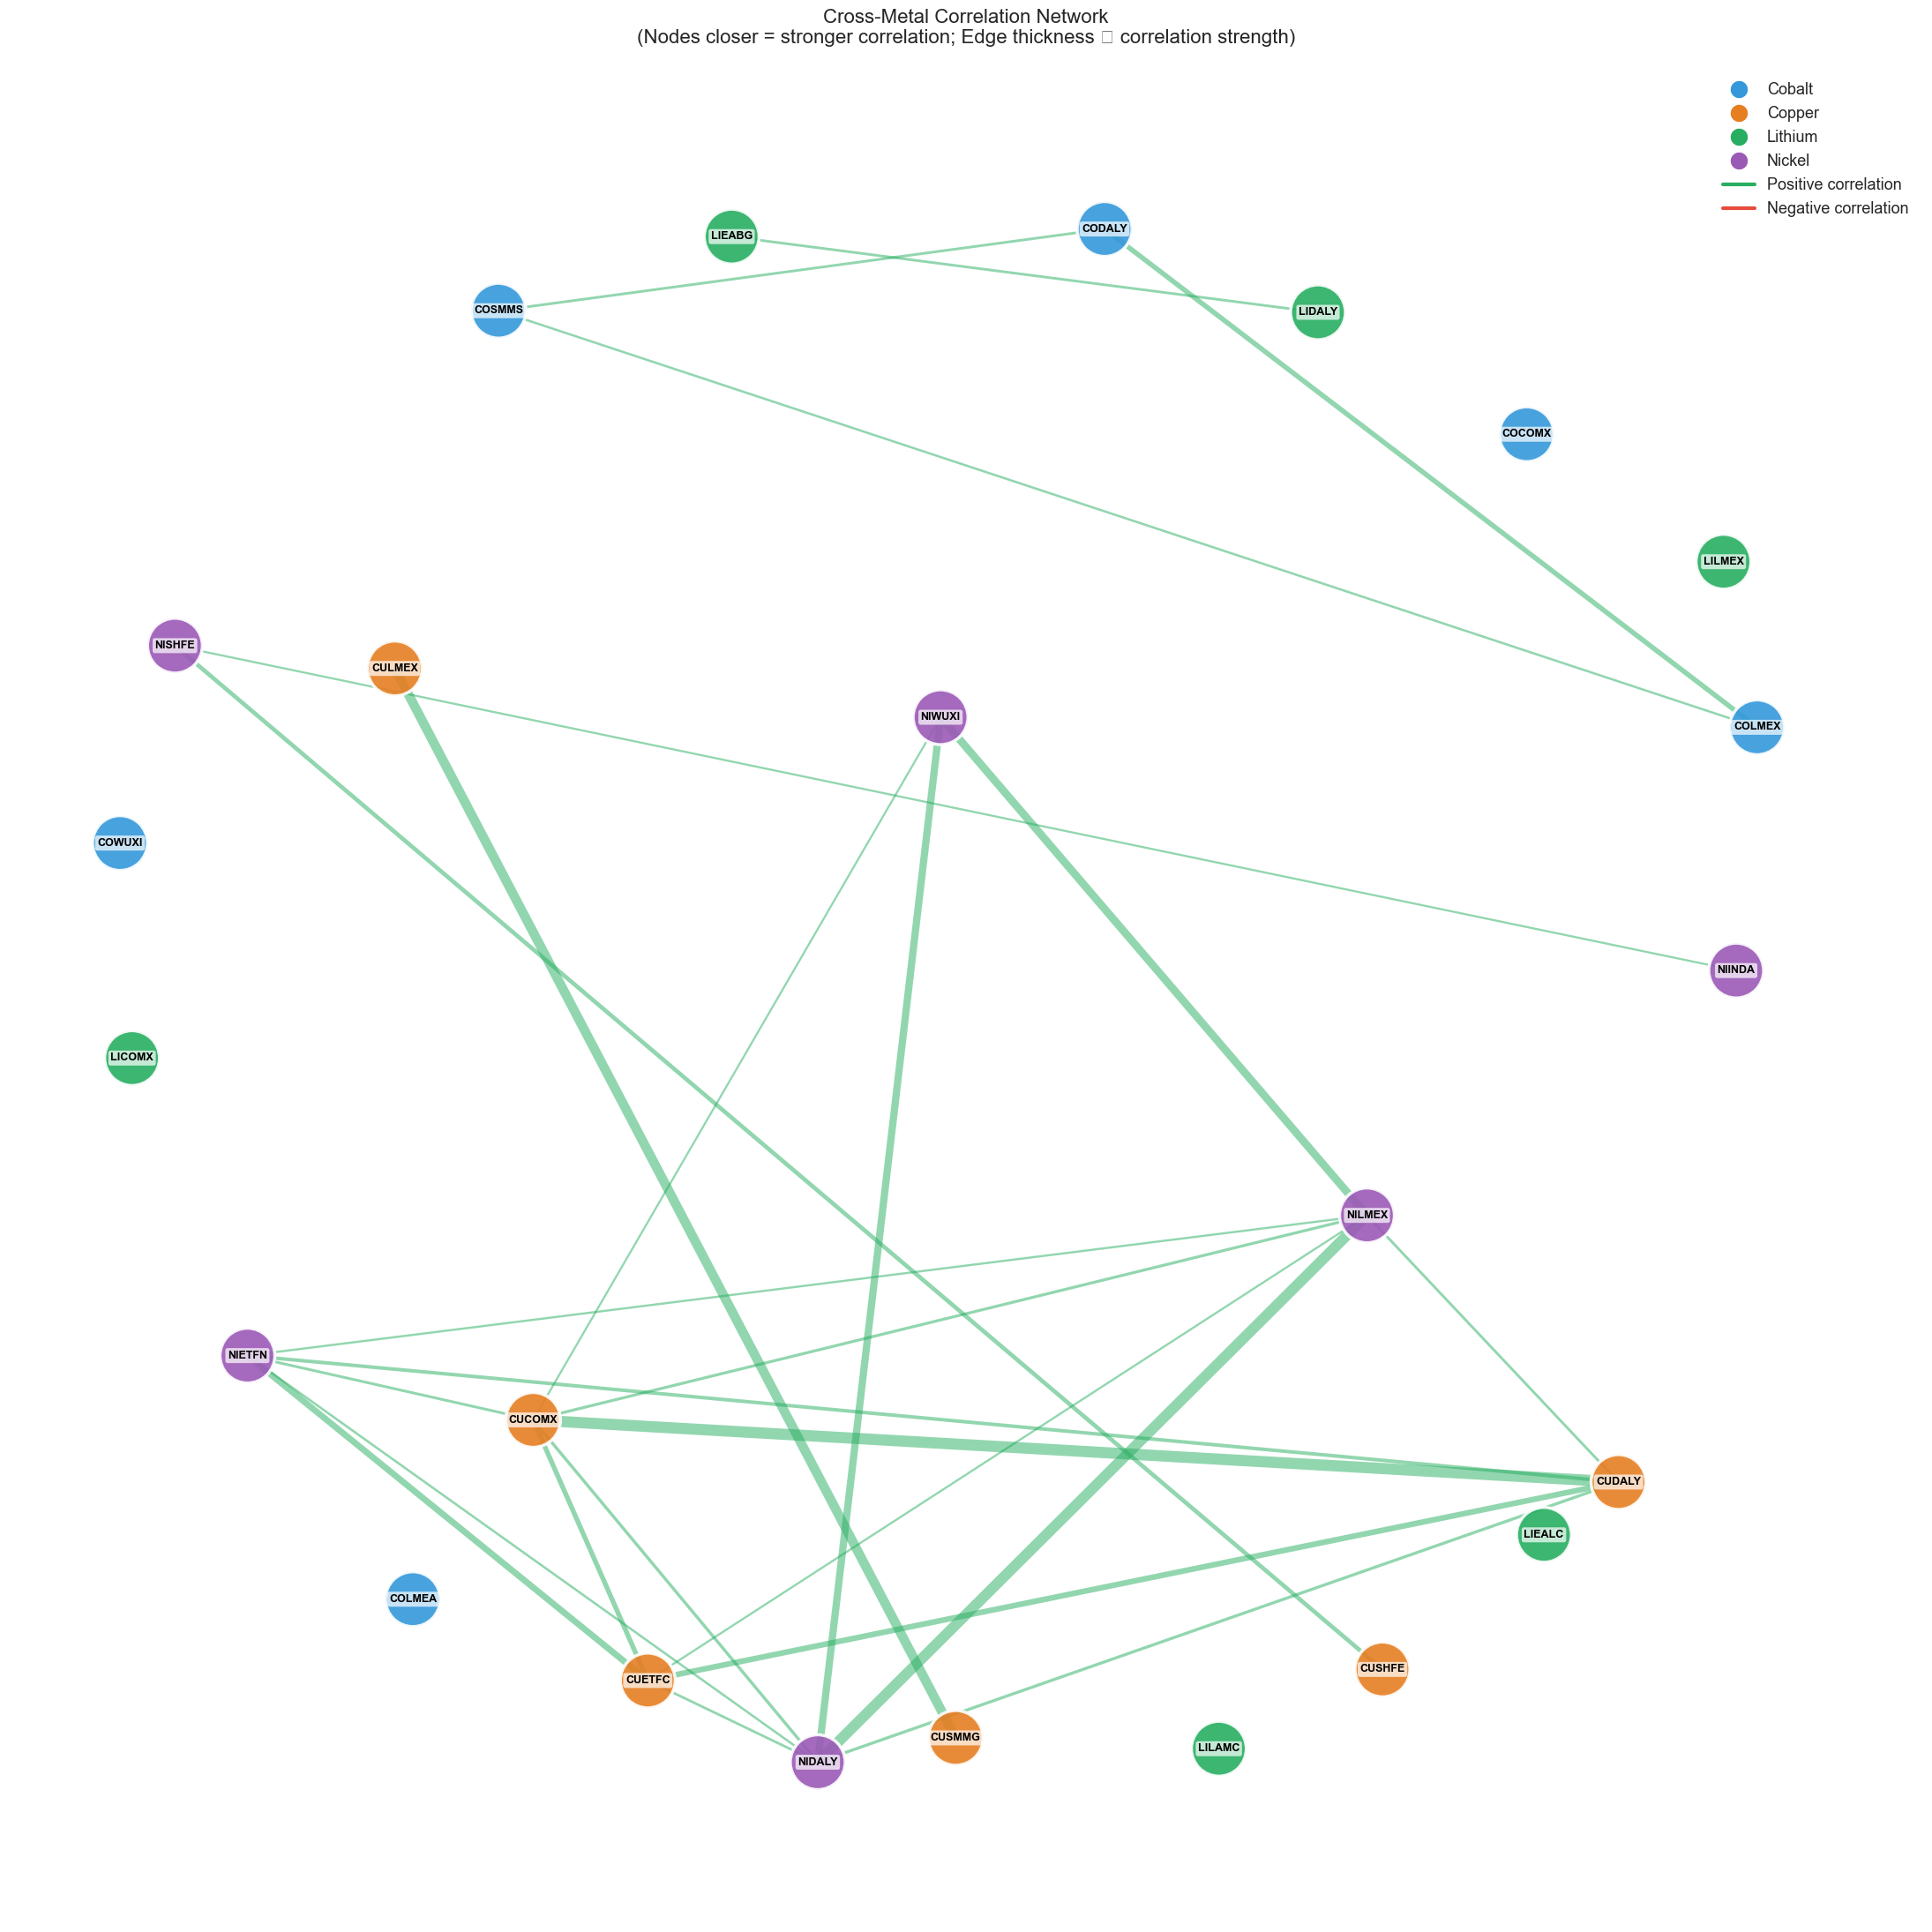

In [10]:
# Create network visualization
fig, ax = plt.subplots(figsize=(22, 22))

# Use spring layout where distance is inversely proportional to correlation
# Higher weight = stronger attraction = closer nodes
pos = nx.spring_layout(G, k=3, iterations=100, seed=42, weight='weight')

# Prepare edge colors and widths based on correlation sign and strength
edge_colors = []
edge_widths = []

for u, v in G.edges():
    # Get original signed correlation
    corr = corr_matrix.loc[u, v]
    
    # Color: green for positive, red for negative
    if corr > 0:
        edge_colors.append('#27ae60')  # Green
    else:
        edge_colors.append('#e74c3c')  # Red
    
    # Width: emphasize stronger correlations (multiply by 8 instead of 3)
    edge_widths.append(abs(corr) ** 1.5 * 10)  # Power makes differences more pronounced

# Draw edges with colors and varying thickness
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors)

# Draw nodes colored by metal
nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                       node_size=2000, alpha=0.9, linewidths=2.5, edgecolors='white')

# Add labels (small size to avoid clutter)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', 
                        font_color='black', bbox=dict(boxstyle='round,pad=0.2', 
                        facecolor='white', edgecolor='none', alpha=0.7))

# Add legend for metals
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=color, markersize=15, label=metal)
    for metal, color in metal_colors.items()
]
# Add edge color legend
legend_elements.extend([
    plt.Line2D([0], [0], color='#27ae60', linewidth=3, label='Positive correlation'),
    plt.Line2D([0], [0], color='#e74c3c', linewidth=3, label='Negative correlation')
])

ax.legend(handles=legend_elements, loc='upper right', fontsize=13, framealpha=0.95)

plt.title('Cross-Metal Correlation Network\n(Nodes closer = stronger correlation; Edge thickness ∝ correlation strength)',
          fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

## 6. Within-Metal vs Cross-Metal Correlations

Analyze correlation patterns within and between metals (based on returns).

In [11]:
# Separate within-metal and cross-metal correlations
within_metal_corrs = []
cross_metal_corrs = []

for i, col1 in enumerate(aligned_data.columns):
    metal1 = series_to_metal[col1]
    for col2 in aligned_data.columns[i+1:]:
        metal2 = series_to_metal[col2]
        corr = corr_matrix.loc[col1, col2]
        
        if metal1 == metal2:
            within_metal_corrs.append((metal1, corr))
        else:
            cross_metal_corrs.append((f"{metal1}-{metal2}", corr))

print("Within-metal correlations:")
print(f"  Count: {len(within_metal_corrs)}")
print(f"  Mean: {np.mean([c for _, c in within_metal_corrs]):.3f}")
print(f"  Median: {np.median([c for _, c in within_metal_corrs]):.3f}")

print("\nCross-metal correlations:")
print(f"  Count: {len(cross_metal_corrs)}")
print(f"  Mean: {np.mean([c for _, c in cross_metal_corrs]):.3f}")
print(f"  Median: {np.median([c for _, c in cross_metal_corrs]):.3f}")

Within-metal correlations:
  Count: 60
  Mean: 0.192
  Median: 0.142

Cross-metal correlations:
  Count: 216
  Mean: 0.061
  Median: 0.036


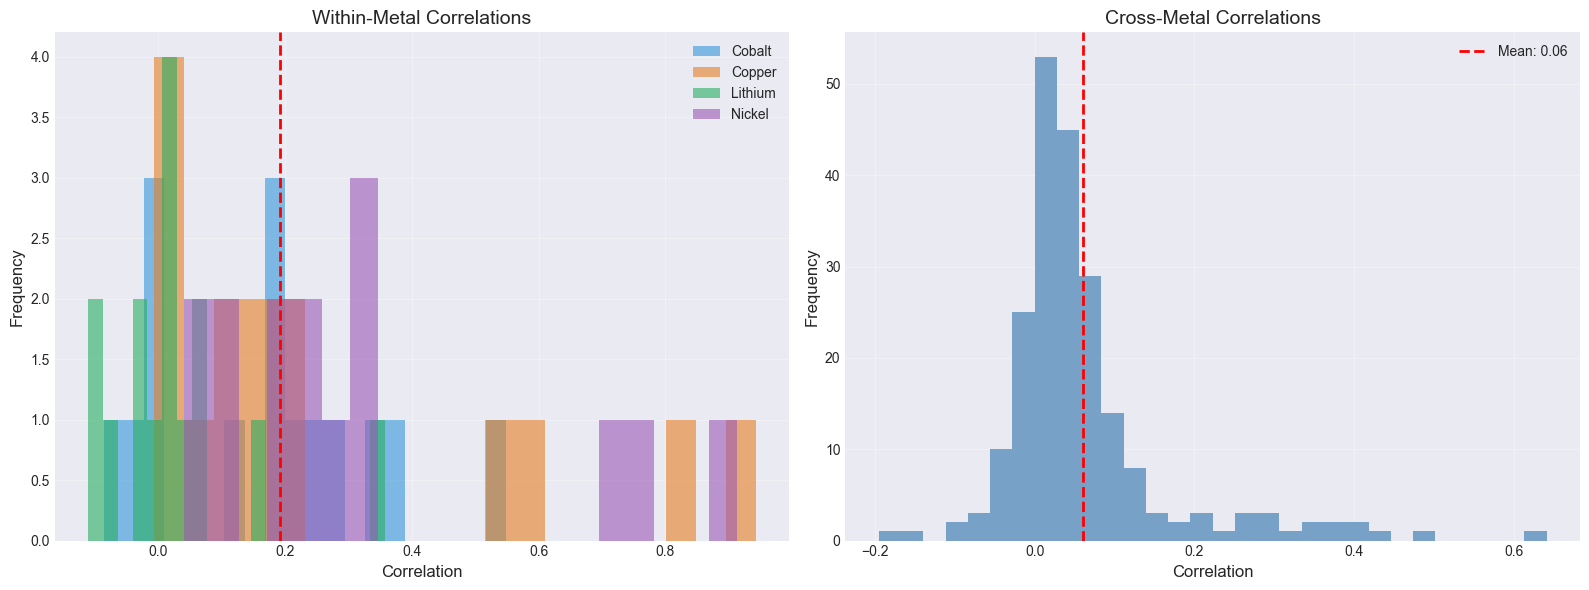

In [12]:
# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Within-metal
for metal in metals.keys():
    metal_corrs = [c for m, c in within_metal_corrs if m == metal]
    if metal_corrs:
        axes[0].hist(metal_corrs, bins=20, alpha=0.6, label=metal, color=metal_colors[metal])

axes[0].set_xlabel('Correlation', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Within-Metal Correlations', fontsize=14)
axes[0].legend()
axes[0].axvline(np.mean([c for _, c in within_metal_corrs]), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {np.mean([c for _, c in within_metal_corrs]):.2f}')
axes[0].grid(alpha=0.3)

# Cross-metal
axes[1].hist([c for _, c in cross_metal_corrs], bins=30, alpha=0.7, color='steelblue')
axes[1].set_xlabel('Correlation', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Cross-Metal Correlations', fontsize=14)
axes[1].axvline(np.mean([c for _, c in cross_metal_corrs]), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {np.mean([c for _, c in cross_metal_corrs]):.2f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Key Insights

**Timeframe:** The analysis uses the common period where all series have sufficient data coverage.

**Correlation Patterns:**
- Within-metal correlations tend to be higher (series from the same metal move together)
- Cross-metal correlations reveal economic relationships between different commodity markets
- The network graph reveals natural clustering, with some cross-metal connections indicating shared market drivers

**Network Structure:**
- Node colors clearly distinguish the 4 metals
- Edge thickness shows correlation strength
- Community detection may reveal groups of series that move together regardless of metal type
- Isolated nodes or clusters suggest series with unique price dynamics